In [2]:
import os
import  matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import Window
import numpy as np
import csv
import fiona
import skgstat as skg
from skgstat import Variogram

from tools_AA_IR import reading_gps_file, circle_sensor, plottingtemp_single_label_IR
from tools_AA_IR import path_IR, get_tif,get_value_IR 
from tools_AA_IR import circle_to_shape, readingIR , IR_mask, readingIR_all
from tools_AA import readingtemp_AA, slice_raw, path_sonde, name_sonde, plottingtemp_single_label
from tools_EL import readingtemp, plottingtemp
from tools_AA_VIS import readingVIS,VIS_mask , norm, requested_VIS_AOI,norm_tif,get_requested_tif,hsv
from tools_AA_VIS import hsv_tif,hsv, re_sampling, greeness_tif
from tools_AA_variograms import reading_3band, reading_cluster


In [3]:
dict_labels_hsv = {}

In [4]:
dict_labels_vis = {}

# Clustering

### Importation des donnees

In [5]:
#filename = './traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif'
#filename_hsv = './traitement_PIREN/vis_piren_phase_HSV.tif'
#filename_norm = './traitement_PIREN/vis_piren_phase_normalized.tif'
#filename_IR   = './traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'

filename = './traitement_PIREN/vis_piren_phase_1_cropped.tif'
filename_hsv = './traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif'
filename_norm = './traitement_PIREN/vis_piren_phase_1_cropped_norm.tif'
filename_IR   = './traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'

with rio.open(filename) as dataset : 
    all_band = dataset.read()
    Red=dataset.read(1)
    Green=dataset.read(2)
    Blue=dataset.read(3)
RGB= np.dstack((Red, Green, Blue)) # On refait un pseudo RGB
RGB=RGB.astype('float32') # Je veut juste etre sur que c'est du float
    
with rio.open(filename_hsv) as datahsv : 
    all_band_hsv = datahsv.read()
    Hue=datahsv.read(1)
    Saturation=datahsv.read(2)
    Value=datahsv.read(3)
    
Hue=Hue.astype('f4')
Saturation=Saturation.astype('f4')
Value=Value.astype('f4')
HSV= np.dstack((Hue, Saturation, Value)) # On refait un pseudo RGB
HSV=HSV.astype('float32') # Je veut juste etre sur que c'est du float

with rio.open(filename_norm) as dataset : 
    all_band_norm = dataset.read()
    Red_N=dataset.read(1)
    Green_N=dataset.read(2)
    Blue_N=dataset.read(3)
Red_N=Red_N.astype('f4')
Green_N=Green_N.astype('f4')
Blue_N=Blue_N.astype('f4')
RGB_N= np.dstack((Red_N, Green_N, Blue_N)) # On refait un pseudo RGB
RGB_N=RGB_N.astype('float32') # Je veut juste etre sur que c'est du float


In [8]:
type(RGB[0][0][0])

numpy.float32

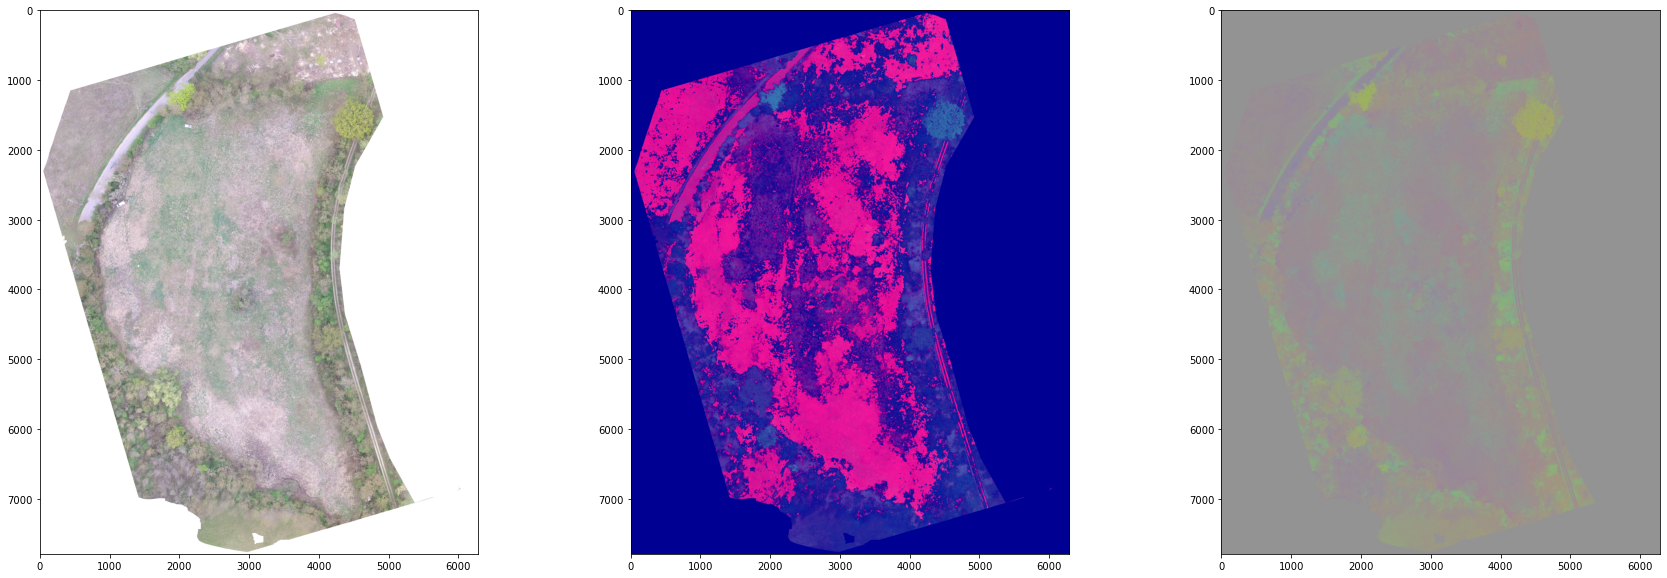

In [63]:
figg,ax1 = plt.subplots(1,3,figsize=(30,10))
ax1[0].imshow(RGB.astype(rio.uint8))
ax1[1].imshow(HSV)
ax1[2].imshow(RGB_N)

# Visible

labels array is the cluster label for each pixel which is either 0,1,2,3,4,5(since k = 5),
centers refers to the center points (each centroid's value).

cv2.KMEANS_RANDOM_CENTERS just indicates OpenCV to randomly assign the values of the clusters initially.



In [82]:
print("RGB :",RGB.shape)
print("all_band :",all_band.shape)

## !!!!!!!!!!!!! On peut convertir du 2D en 1D avec la fonction reshape
RGB.reshape((-1,3)).shape
pixel = RGB.reshape((-1,3))
print("pixel :",pixel.shape)

RGB : (7790, 6287, 3)
all_band : (3, 7790, 6287)
pixel : (48975730, 3)


In [83]:
# Epsilon = 0.2 , Number of iteration = 100
import cv2 ## pour de la classification
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [84]:
k = 8
_,labels_vis,(centers_vis) = cv2.kmeans(pixel,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [86]:
#convert back to 8 bit values
centers_vis = np.uint8(centers_vis)

#flatten the labels array
labels_vis = labels_vis.flatten()

segmented_labels_vis = labels_vis.reshape(RGB[:,:,0].shape)
segmented_labels_vis.max()

dict_labels_vis[k]={"labels" : labels_vis,
                   "centers" : centers_vis,
                   "segmented_labels" : segmented_labels_vis}

In [87]:
dict_labels_vis

{8: {'labels': array([5, 5, 5, ..., 5, 5, 5], dtype=int32),
  'centers': array([[ 82,  84,  76],
         [ 89,  94,  83],
         [ 82, 105,  77],
         [101,  95,  97],
         [140, 156, 144],
         [ 93,  93,  93],
         [ 86,  87,  89],
         [ 68,  79,  66]], dtype=uint8),
  'segmented_labels': array([[5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5],
         ...,
         [5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5],
         [5, 5, 5, ..., 5, 5, 5]], dtype=int32)}}

In [91]:
l = k
segmented_labels_vis = dict_labels_vis[l]["segmented_labels"]

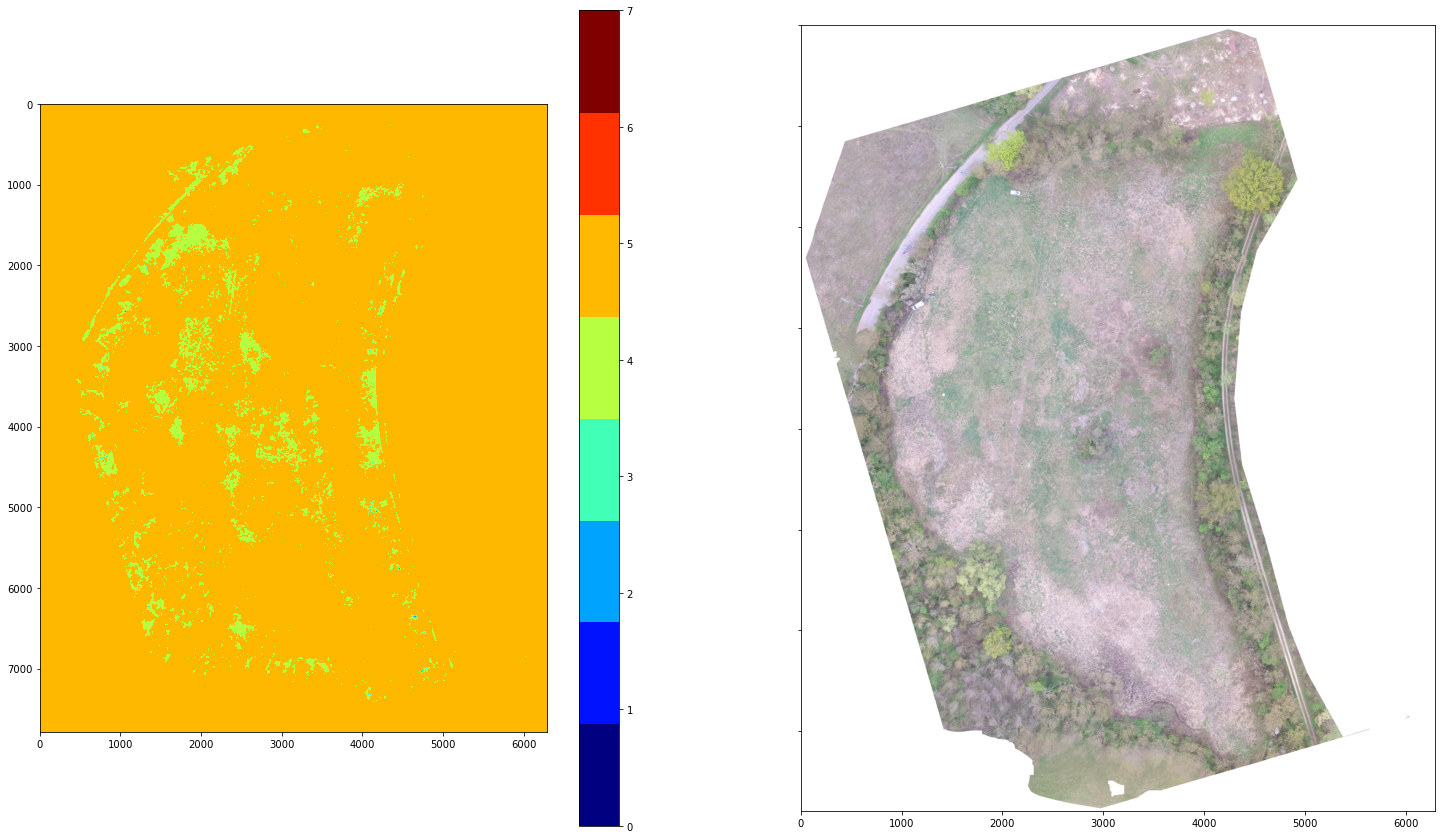

In [92]:
# reshape back to the original image dimension
ole=cm.get_cmap('jet', l)
#segmented_image = segmented_image.reshape(RGB.shape)
figi,ax=plt.subplots(1,2,figsize=(25,15),sharex=True,sharey=True)

# show the image
#plt.imshow(segmented_image[:,:,0],cmap='Reds')
hehe=ax[0].imshow(segmented_labels_vis,cmap=ole)
#plt.imshow(segmented_labels,cmap=ole)
plt.colorbar(hehe,ax=ax[0])
ax[1].imshow(RGB.astype(int))

### Sauvegarde d'un .tif Visible

In [106]:
filename_vis = './traitement_PIREN/vis_piren_phase_1_cropped.tif'
with rio.open(filename_vis) as VIS_src :
    print("VIS_src :",VIS_src)
    profile = {
        "driver": "GTiff",
        "count": 1,
        "height": VIS_src.shape[0],
        "width": VIS_src.shape[1],
        'dtype': 'uint8',
        'transform': VIS_src.transform,
        "meta" : VIS_src.meta ,
        "bounds": VIS_src.bounds ,
        "crs": VIS_src.crs ,
        "res": VIS_src.res }
    
    n = segmented_labels_vis.max()+1
    fileout_cluster_vis = filename_vis[0:filename_vis.find(".tif")] + '_clustered_'+str(n)+'k.tif'
    with rio.open(fileout_cluster_vis, 'w', **profile) as dst :
        dst.write(segmented_labels_vis.astype(rio.uint8),1)
        print("fichier crée :",fileout_cluster_vis)

VIS_src : <open DatasetReader name='./traitement_PIREN/vis_piren_phase_1_cropped.tif' mode='r'>
fichier crée : ./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif


In [107]:
fileout_cluster_vis

'./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif'

### Originale Visible

In [108]:
request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
#filetif = ['.tif']
#filetif,requested_path = hsv_tif(filetif)

filetif = ['vis_piren_phase_clustered_6k']

requested_names, requested_shapes, ls_mask_image, ls_out_transform,Piren_VIS,sensor_coord = requested_VIS_AOI(filetif,request_sensor,10)

['./traitement_PIREN/vis_piren_phase_clustered_6k.tif', './traitement_PIREN/vis_piren_phase_clustered_6k_resampled_3.tif', './traitement_PIREN/vis_piren_phase_clustered_6k_resampled_5.tif']
nombre de shapes 10


In [109]:
# Fichier .tif contenant les clusters 
fileout_cluster_vis = filename_vis[0:filename_vis.find(".tif")] + '_clustered_'+str(n)+'k.tif'
print("file cluster :",fileout_cluster_vis)
dict_windows_cluster, dict_windows_param_cluster = reading_cluster(10,fileout_cluster_vis)

# Fichier original 

#filename_vis = './traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif'
print("file 3band :",filename_vis)
dict_windows, dict_windows_param = reading_3band(10,filename_vis,False)

file cluster : ./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif
Taille de la fenetre : 252 x 252
file 3band : ./traitement_PIREN/vis_piren_phase_1_cropped.tif
Taille de la fenetre : 252 x 252


### Re-sampled Visible

In [110]:
# Fichier .tif contenant les clusters 
fileout_cluster_vis = filename_vis[0:filename_vis.find(".tif")] + '_clustered_'+str(l)+'k.tif'
fileout_cluster_vis_sampled = fileout_cluster_vis
print("file cluster to sample :",fileout_cluster_vis_sampled)

data_cluster_sampled , fileout_cluster_sampled = re_sampling(fileout_cluster_vis_sampled,3)
print(fileout_cluster_sampled)
dict_windows_cluster_sampled, dict_windows_param_cluster_sampled = reading_cluster(10,fileout_cluster_sampled)


# Fichier original sampled
fileout_vis_sampled = filename_vis
#fileout_vis_sampled = './traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif'

data_sampled , fileout_sampled = re_sampling(fileout_vis_sampled,3)
print("file 3band to sample :",fileout_vis_sampled)
dict_windows_sampled, dict_windows_param_sampled = reading_3band(10,fileout_sampled,False)

file cluster to sample : ./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif
./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k_resampled_3.tif
Taille de la fenetre : 84 x 84
file 3band to sample : ./traitement_PIREN/vis_piren_phase_1_cropped.tif
Taille de la fenetre : 84 x 84


### Histogrammes Visible

In [111]:
# Choix de l'image originale/sampled

dict_windows_cluster       = dict_windows_cluster
dict_windows_param_cluster = dict_windows_param_cluster

dict_windows       = dict_windows
dict_windows_param = dict_windows_param

dict_histogram = {}

for target in dict_windows_cluster :
    n = dict_windows_cluster[target]["label"].max() + 1 # NOMBRE DE CLUSTER
    print(target)
    ls_histo = []
    for i in range(n) :
        label = dict_windows_cluster[target]["label"]
        val = np.extract(label==i,label)
        ls_histo.append((val.shape[0]/label.shape[0])*100)
    ls_histo
    dict_histogram[target] = ls_histo
    

S10
S1
S9
S2
S4
S5
S8
S7
S6
S3-AIR


In [ ]:
print(l)

### Affichage des histo Visible

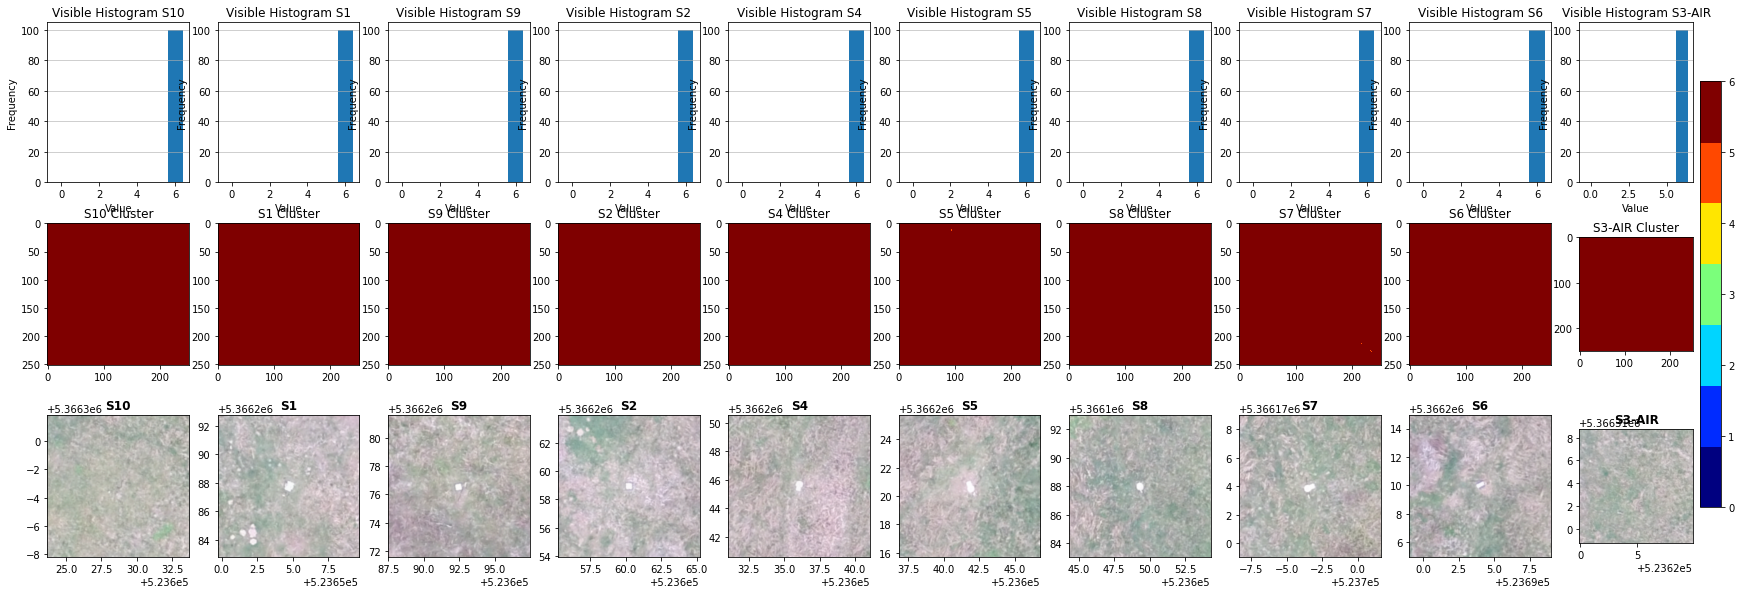

In [112]:
fig3,axhs = plt.subplots(3,len(dict_windows_cluster),figsize = (30,10))
ole=cm.get_cmap('jet', l)

for i,target in enumerate(dict_windows_cluster) :
    
    x = np.arange(n)
    axhs[0,i].bar(x,height = ls_histo)
    axhs[0,i].grid(axis='y', alpha=0.75)
    axhs[0,i].set_xlabel('Value')
    axhs[0,i].set_ylabel('Frequency')
    axhs[0,i].set_title('Visible Histogram '+target)
    
    window_cluster = dict_windows_param_cluster[target]["all_band"]
    window_cluster_transform = dict_windows_param_cluster[target]["win_transform"]
    #show(window_hsv,transform = window_transform_hsv,ax = axhs[1,i],title = "Cluster")
    sub_fig = axhs[1,i].imshow(window_cluster,cmap = ole,vmin = 0,vmax = l-1)
    axhs[1,i].set_title(target +' Cluster')
    
    
    window_vis = dict_windows_param[target]["all_band"]
    window_transform_vis = dict_windows_param[target]["win_transform"]
    show(window_vis,transform = window_transform_vis,ax = axhs[2,i],title = target)
    
fig3.colorbar(sub_fig,ax = axhs[:,-1])
 
    
    
    

# ------------------------------------------------------------------------------------------------------------

# HSV

labels array is the cluster label for each pixel which is either 0,1,2,3,4,5(since k = 5),
centers refers to the center points (each centroid's value).

cv2.KMEANS_RANDOM_CENTERS just indicates OpenCV to randomly assign the values of the clusters initially.



In [6]:
print("HSV :",HSV.shape)
print("all_band_hsv :",all_band_hsv.shape)

## !!!!!!!!!!!!! On peut convertir du 2D en 1D avec la fonction reshape
HSV.reshape((-1,3)).shape
pixel_hsv = HSV.reshape((-1,3))
print("pixel_hsv :",pixel_hsv.shape)

HSV : (7790, 6287, 3)
all_band_hsv : (3, 7790, 6287)
pixel_hsv : (48975730, 3)


In [7]:
# Epsilon = 0.2 , Number of iteration = 100
import cv2 ## pour de la classification
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [31]:
k = 7
_,labels_hsv,(centers_hsv) = cv2.kmeans(pixel_hsv,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)


In [32]:
#convert back to 8 bit values
centers_hsv = np.uint8(centers_hsv)

#flatten the labels array
labels_hsv = labels_hsv.flatten()

segmented_labels_hsv = labels_hsv.reshape(HSV[:,:,0].shape)
segmented_labels_hsv.max()

dict_labels_hsv[k]={"labels" : labels_hsv,
                   "centers" : centers_hsv,
                   "segmented_labels" : segmented_labels_hsv}

In [52]:
dict_labels_hsv

{6: {'labels': array([4, 4, 4, ..., 4, 4, 4], dtype=int32),
  'centers': array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]], dtype=uint8),
  'segmented_labels': array([[4, 4, 4, ..., 4, 4, 4],
         [4, 4, 4, ..., 4, 4, 4],
         [4, 4, 4, ..., 4, 4, 4],
         ...,
         [4, 4, 4, ..., 4, 4, 4],
         [4, 4, 4, ..., 4, 4, 4],
         [4, 4, 4, ..., 4, 4, 4]], dtype=int32)},
 8: {'labels': array([2, 2, 2, ..., 2, 2, 2], dtype=int32),
  'centers': array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]], dtype=uint8),
  'segmented_labels': array([[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         ...,
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]], dtype=int32)},
 7: {'labels': array([3, 3, 3, ..., 3, 3

In [66]:
j = k
segmented_labels_hsv = dict_labels_hsv[j]["segmented_labels"]


7

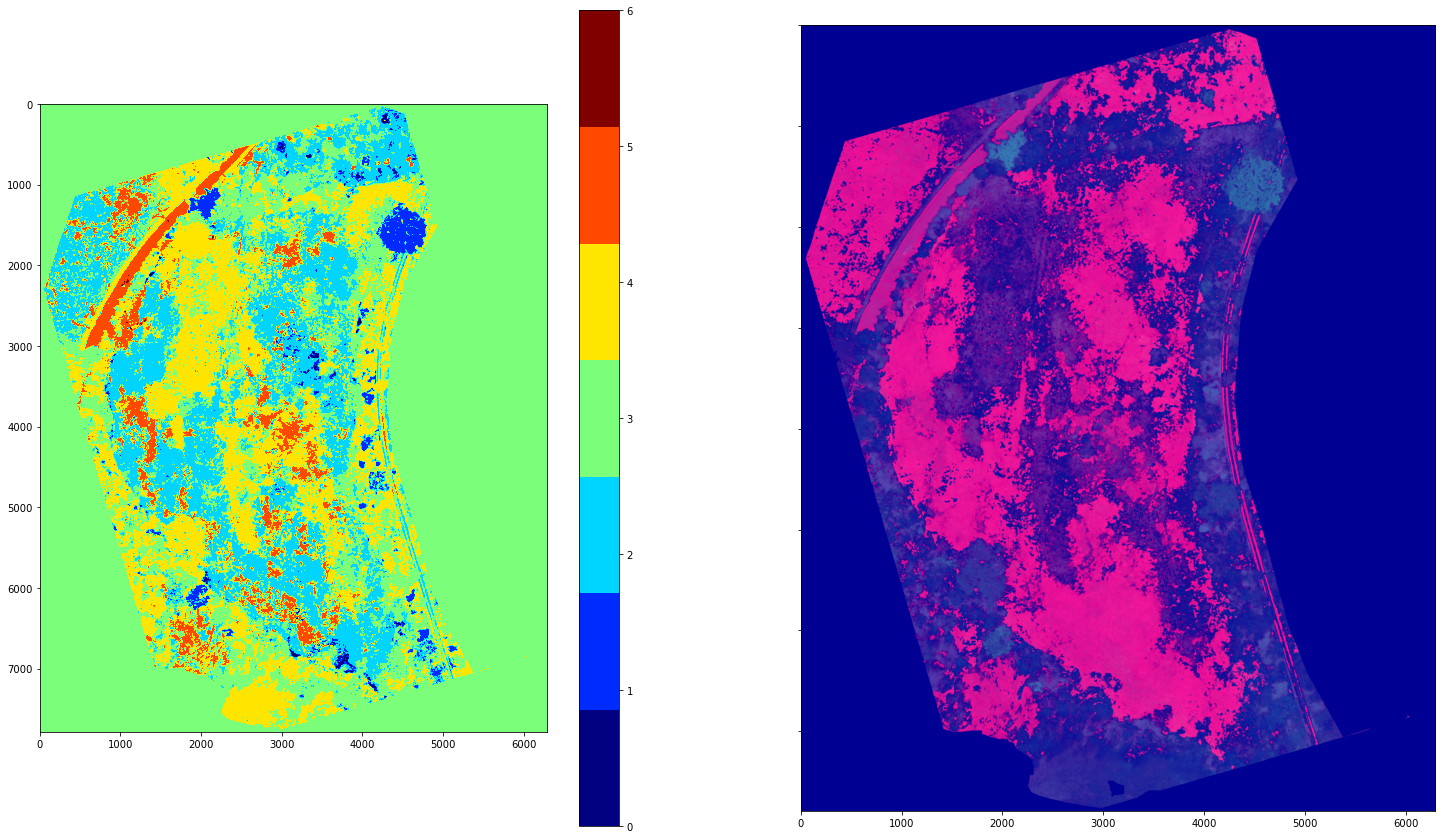

In [68]:
# reshape back to the original image dimension
ole=cm.get_cmap('jet', j)
#segmented_image = segmented_image.reshape(RGB.shape)
figi,ax=plt.subplots(1,2,figsize=(25,15),sharex=True,sharey=True)

# show the image
#plt.imshow(segmented_image[:,:,0],cmap='Reds')
hehe=ax[0].imshow(segmented_labels_hsv,cmap=ole)
#plt.imshow(segmented_labels,cmap=ole)
plt.colorbar(hehe,ax=ax[0])
ax[1].imshow(HSV.astype(rio.float32))

### Sauvegarde d'un .tif HSV

In [69]:
filename_hsv = './traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif'
with rio.open(filename_hsv) as VIS_src :
    print("VIS_src :",VIS_src)
    profile = {
        "driver": "GTiff",
        "count": 1,
        "height": VIS_src.shape[0],
        "width": VIS_src.shape[1],
        'dtype': 'uint8',
        'transform': VIS_src.transform,
        "meta" : VIS_src.meta ,
        "bounds": VIS_src.bounds ,
        "crs": VIS_src.crs ,
        "res": VIS_src.res }
    n = segmented_labels_hsv.max()+1
    fileout_cluster_hsv = filename_hsv[0:filename_hsv.find(".tif")] + '_clustered_'+str(n)+'k.tif'
    with rio.open(
        fileout_cluster_hsv, 'w',
        **profile) as dst: # count : nombre de band
        dst.write(segmented_labels_hsv.astype(rio.uint8),1)

VIS_src : <open DatasetReader name='./traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif' mode='r'>


### Originale HSV

In [35]:
request_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
#filetif = ['.tif']
#filetif,requested_path = hsv_tif(filetif)

filetif_hsv = ['vis_piren_phase_1_cropped_HSV_clustered_6k']

requested_names, requested_shapes, ls_mask_image_hsv, ls_out_transform,Piren_VIS,sensor_coord = requested_VIS_AOI(filetif_hsv,request_sensor,10)

['./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_6k.tif', './traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_6k_2.tif', './traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_6k_2_resampled_3.tif', './traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_6k_resampled_3.tif']
nombre de shapes 10


In [70]:
# Fichier .tif contenant les clusters 
j = segmented_labels_hsv.max()+1
fileout_cluster_hsv = filename_hsv[0:filename_hsv.find(".tif")] + '_clustered_'+str(j)+'k.tif'
print("file cluster :",fileout_cluster_hsv)
dict_windows_cluster_hsv, dict_windows_param_cluster_hsv = reading_cluster(10,fileout_cluster_hsv)

# Fichier original 
print("file 3band :",filename_hsv)
dict_windows_hsv, dict_windows_param_hsv = reading_3band(10,filename_hsv,False)

file cluster : ./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif
Taille de la fenetre : 252 x 252
file 3band : ./traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif
Taille de la fenetre : 252 x 252


### Re-sampled HSV

In [37]:
# Fichier .tif contenant les clusters 
fileout_cluster_hsv_sampled = fileout_cluster_hsv
print("file cluster to sample :",fileout_cluster_hsv_sampled)

data_cluster_sampled , fileout_cluster_sampled = re_sampling(fileout_cluster_hsv_sampled,3)
print(fileout_cluster_sampled)
dict_windows_cluster_hsv_sampled, dict_windows_param_cluster_hsv_sampled = reading_cluster(10,fileout_cluster_sampled)

# Fichier original sampled
fileout_hsv_sampled = filename_hsv
print("file 3band to sample :",fileout_hsv_sampled)
data_sampled , fileout_sampled = re_sampling(fileout_hsv_sampled,3)
print(fileout_hsv_sampled)
dict_windows_hsv_sampled, dict_windows_param_hsv_sampled = reading_3band(10,fileout_hsv_sampled,False)

file cluster to sample : ./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif
./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k_resampled_3.tif
Taille de la fenetre : 84 x 84
file 3band to sample : ./traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif
./traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif
Taille de la fenetre : 252 x 252


### Histogrammes HSV

In [75]:
# Choix de l'image originale/sampled

dict_windows_cluster       = dict_windows_cluster_hsv
dict_windows_param_cluster = dict_windows_param_cluster_hsv

dict_windows       = dict_windows_hsv 
dict_windows_param = dict_windows_param_hsv

dict_histogram = {}

for target in dict_windows_cluster :
    n = dict_windows_cluster[target]["label"].max() + 1 # NOMBRE DE CLUSTER
    print(target)
    ls_histo = []
    for i in range(n) :
        label = dict_windows_cluster[target]["label"]
        val = np.extract(label==i,label)
        ls_histo.append((val.shape[0]/label.shape[0])*100)
    ls_histo
    dict_histogram[target] = ls_histo
    

S10
S1
S9
S2
S4
S5
S8
S7
S6
S3-AIR


Ajout des patch visibles pour comparer

In [72]:
# Fichier visible 
fileout_vis = './traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif'
dict_windows_vis, dict_windows_param_vis = reading_3band(10,fileout_vis,False)

Taille de la fenetre : 252 x 252


In [78]:
target

'S10'

### Affichage des histo HSV

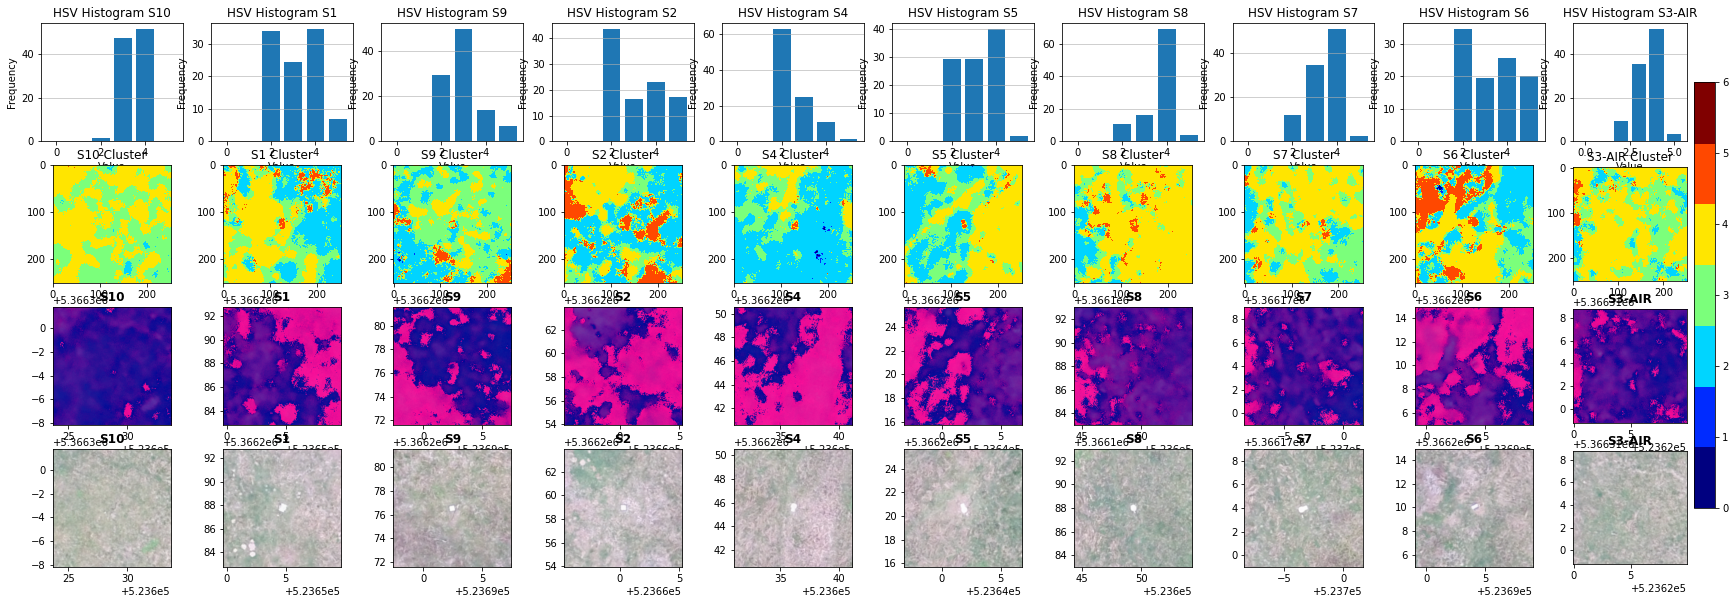

In [79]:
j = segmented_labels_hsv.max()+1
fig3,axhs = plt.subplots(4,len(dict_windows_cluster),figsize = (30,10))
ole=cm.get_cmap('jet',j)

for i,target in enumerate(dict_windows_cluster) :
    
    x = np.arange(j-1)
    axhs[0,i].bar(x,height = dict_histogram[target])
    axhs[0,i].grid(axis='y', alpha=0.75)
    axhs[0,i].set_xlabel('Value')
    axhs[0,i].set_ylabel('Frequency')
    axhs[0,i].set_title('HSV Histogram '+target)
    
    window_cluster = dict_windows_param_cluster[target]["all_band"]
    window_cluster_transform = dict_windows_param_cluster[target]["win_transform"]
    #show(window_hsv,transform = window_transform_hsv,ax = axhs[1,i],title = "Cluster")
    sub_fig = axhs[1,i].imshow(window_cluster,cmap = ole,vmin = 0,vmax = j-1)
    axhs[1,i].set_title(target +' Cluster')
    
    
    window_hsv = dict_windows_param[target]["all_band"]
    window_transform_hsv = dict_windows_param[target]["win_transform"]
    show(window_hsv,transform = window_transform_hsv,ax = axhs[2,i],title = target)
    
    window_vis = dict_windows_param_vis[target]["all_band"]
    window_transform_vis = dict_windows_param_vis[target]["win_transform"]
    show(window_vis,transform = window_transform_vis,ax = axhs[3,i],title = target)
    
    
    
fig3.colorbar(sub_fig,ax = axhs[:,-1])
 
    
    
    

# ANNEXE

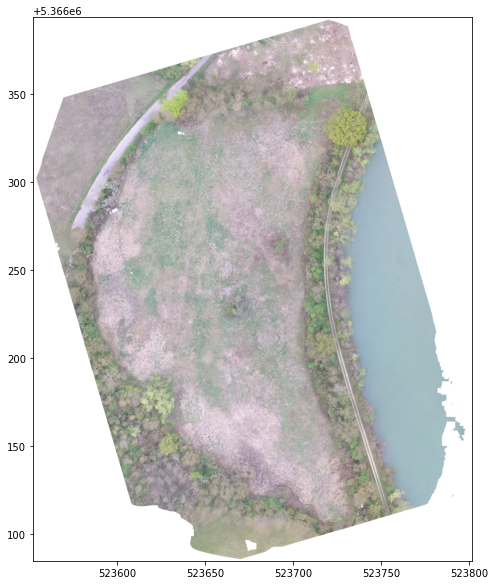

In [139]:
fig1,axrgb = plt.subplots(1,figsize=(30,10))

show(all_band, transform=all_band_transform,ax = axrgb  )
plt.show()


In [ ]:
# """
# Plot all shapes around all targets"""

    for k in range(len(list_coord_poly)):

        plt.plot(list_coord_poly[k][0], list_coord_poly[k][1], color='#6699cc', alpha=0.7,linewidth=3, solid_capstyle='round', zorder=2)
        plt.show()

In [202]:
def reading_TEST(LONGUEUR,filename='./traitement_PIREN/vis_piren_phase_HSV.tif',normalization = True) :
    """ Lit un fichier .tif à 3 bands et retourne un patch carré de coté LONGUEUR au format csv pour l'execution d'un variogram
    """
    #filename = './traitement_PIREN/vis_piren_phase_HSV.tif'
    #LONGUEUR = 10
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    sensor_coord = reading_gps_file(filename_Sensor_txt)
    with rio.open(filename) as dataset :
        #Value par défaut
        #win_height = 6303
        #win_width = 3421

        ls_index_target = [] # liste des valeurs indexées dans l'image
        win_height = round(LONGUEUR / dataset.res[0])
        win_width  = round(LONGUEUR / dataset.res[1])
        print("Taille de la fenetre :",win_height,"x",win_width)

        # Loop pour recuperer les coordonnées UTM et convertir en indice 
        for k in range(len(sensor_coord["SensorName"])) :
            x = sensor_coord["x"][k] 
            y = sensor_coord["y"][k]
            target = dataset.index(float(x),float(y))
            ls_index_target.append(target)

        dict_windows = {} # liste des paramètres dans la création d'une window
        dict_windows_param = {} # dict des targets : améliore la lisibilité

        for i,index_target in enumerate(ls_index_target) :
            print("x :",index_target[0]," y :",index_target[1])
            win = Window.from_slices((index_target[0]-(win_height//2),(index_target[0]+(win_height//2))),
                                     (index_target[1]-(win_width//2),(index_target[1]+(win_width//2)))
                                     )
            win_transform = dataset.window_transform(win)
            all_band = dataset.read([1,2,3],window = win) # en cas de visualisation

            dict_param = {"win" : win,
                            "win_transform" : win_transform,
                           "all_band" : all_band,
                           "SensorName" : sensor_coord["SensorName"][i]}

            dict_windows_param[sensor_coord["SensorName"][i]] = dict_param

            # Vecteurs linéaires avec valeurs uniforméments crées
            x_start = win_transform[2]
            x_res   = win_transform[0]
            x_end   = x_start+(float(x_res)*win.width)

            y_end   = win_transform[5]
            y_res   = win_transform[4]
            y_start = y_end + (float(y_res)*win.height)

            #print("x_end =",x_end)
            #print("y_start =",y_start)

            x = np.linspace(x_start,x_end,num = win.width)
            y = np.linspace(y_start,y_end,num = win.height)

            band_1 = []
            band_2 = []
            band_3 = []
            band_RGB = []
            band_greeness =[]
            x_matrix = []
            y_matrix = []
            # Loop pour obtenir la valeur de chaque pt pour chaque band
            if normalization == False :
                for j in range(len(x)) :
                    for l in range(len(y)) :
                        for val in dataset.sample([(x[j],y[l])]): 
                            R = val[0]
                            G = val[1]
                            B = val[2]
                            band_1.append(R)
                            band_2.append(G)
                            band_3.append(B)
                            x_matrix.append(x[j]) # permet de répeter le terme 
                            y_matrix.append(y[l])
                            mapping = ['x','y','band 1','band 2','band 3']
                DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                                     y_matrix,
                                                     band_1,
                                                     band_2,
                                                     band_3],dtype = object).T,
                                           columns=mapping)
                        
   
            DATA_WINDOW['SensorName'] = sensor_coord["SensorName"][i]
            
            dict_windows[sensor_coord["SensorName"][i]] = DATA_WINDOW
         
            
    return dict_windows, dict_windows_param  


In [149]:
dataset = rio.open('./traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif')

In [209]:
dict_windows, dict_windows_param = reading_TEST(10,fileout_vis,False)

Taille de la fenetre : 252 x 252
x : 2447  y : 1927


IndexError: band index 2 out of range (not in (1,))

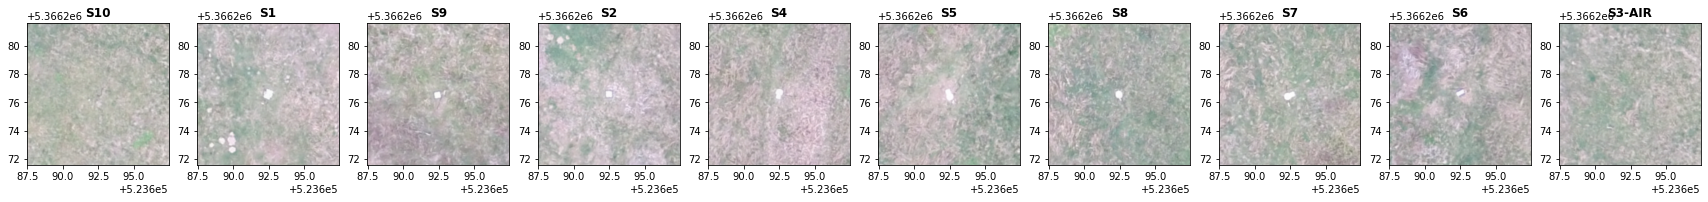

In [208]:
fig1,ax = plt.subplots(1,10,figsize=(30,10))
for i,target in enumerate(dict_windows_param) :
    all_band = dict_windows_param[target]["all_band"]
    transform = dict_windows_param[target]["win_transform"]
    show(all_band,transform = win_transform,ax = ax[i],title = target )

In [10]:
dict_histogram = {}
n = 6 # NOMBRE DE CLUSTER
for target in dict_windows_cluster :
    print(target)
    ls_histo = []
    for i in range(n) :
        label = dict_windows_cluster[target]["label"]
        val = np.extract(label==i,label)
        ls_histo.append((val.shape[0]/label.shape[0])*100)
    ls_histo
    dict_histogram[target] = ls_histo
    

S10
S1
S9
S2
S4
S5
S8
S7
S6
S3-AIR


127

<AxesSubplot:>

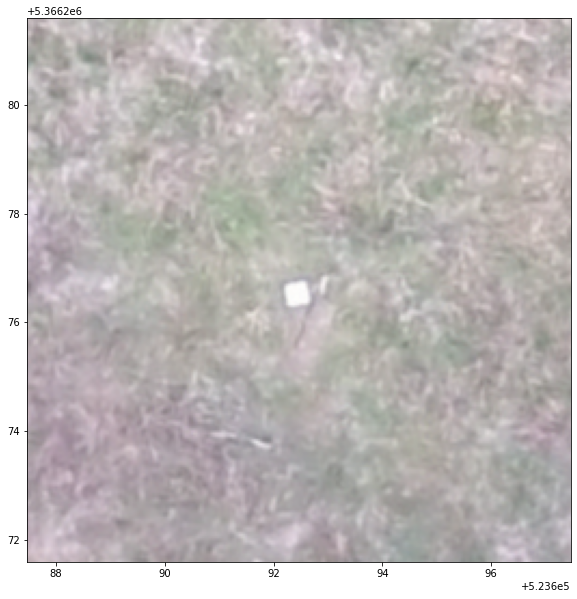

In [199]:
win = Window.from_slices((2957-(252//2),(2957+(252//2))),(3535-(252//2),(3535+(252//2))))
win_transform = dataset.window_transform(win)
all_band = dataset.read([1,2,3],window = win) # en cas de visualisation

